In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats
from tqdm import tqdm
import seaborn as sns
from collections import Counter
from skbio.stats.composition import clr
import copy
import pysam

/home/users/briannac/.local/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [102]:
loci_locations = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/sig_pvals/loci_locations.csv', header=None, sep='\t')

In [103]:
diffs = (loci_locations[0][1:].values-loci_locations[0].iloc[:-1].values)[loci_locations[1][1:].values==loci_locations[1].iloc[:-1].values]

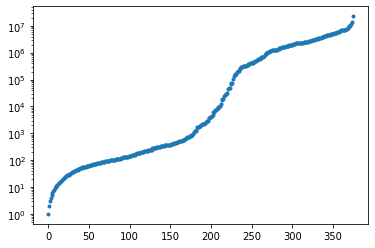

In [104]:
plt.plot(sorted(np.unique(diffs)), '.')
plt.yscale('log')

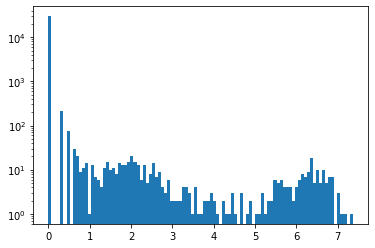

In [105]:
plt.hist(np.log10(diffs), bins=100)
plt.yscale('log')
plt.show()

In [106]:
hits_locations = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/sig_pvals/hits_locations.csv', sep='\t', header=None)

In [108]:
hits_locations

,0,1,2
0,chr10,132282,132293
1,chr10,3628532,3628609
2,chr10,4495909,4495930
3,chr10,4915056,4915059
4,chr10,6667170,6667197
...,...,...,...
553,chr22,29930567,29930583
554,chr22,30454983,30455018
555,chr22,32146222,32146563
556,chr22,38613231,38613271


In [40]:
sum(((hits_locations[1][1:].values-hits_locations[2].iloc[:-1].values)<1000) & (hits_locations[0][1:].values!=hits_locations[0].iloc[:-1].values))

11

In [ ]:
pd.read/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/tsv_files/%s.norm.pvals.tsv

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


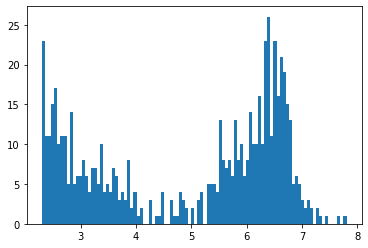

In [49]:
plt.hist(np.log10(hits_locations[1][1:].values-hits_locations[2].iloc[:-1].values)[(hits_locations[0][1:].values==hits_locations[0].iloc[:-1].values)], bins=100)
plt.show()

In [ ]:
# Looking at sequences
bact_seqs = [r for r in SeqIO.parse('/scratch/groups/dpwall/personal/chloehe/unmapped_reads/ref_genome/combined.fa', 'fasta') if 
            ((r.id=='BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|') | (r.id=='BACT_769|gi|223714005|gb|ACDT01000210.1|'))]

In [23]:
samfile = pysam.AlignmentFile("/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/hits_stats/04C34397_aligned_to_assembly.bam",
                              "rb")

In [24]:
iter = samfile.fetch()
info = [(x.cigarstring, x.reference_name, x.query_name.split('_')[0]) if '_' in x.query_name else (x.cigar, x.query_name, 0) for x in iter]

In [32]:
ref_counter = Counter()
for string,ref,query in info:
    if (ref, query) in ref_counter.keys():
        ref_counter[(ref,query)] = ref_counter[(ref,query)] + 1
    else:
        ref_counter[(ref,query)] = 1

In [ ]:
ref_counter.most_common()

In [155]:
bam_dir='/scratch/groups/dpwall/personal/chloehe/unmapped_reads/bam/archived/batch_00514'
bam_mappings = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/data/bam_mappings.csv', sep='\t')
bam_mappings.index = bam_mappings.sample_id
samples = [a.split('/')[-2] for a in glob.glob(bam_dir +'/*/')]
print(samples[2])
print(bam_mappings.loc[samples[2]].sex_numeric)

07C65106
1.0


In [153]:
# Put together stats dataframes.

stats = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/sig_pvals/hits_stats.csv', sep='\t', header=None)
AS_medians = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/hits_stats/07C67140.AS_median.txt', sep='\t')
AS_medians.columns = ['AS_medians']

MAPQ_medians = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/hits_stats/07C67140.MAPQ_median.txt', sep='\t')
MAPQ_medians.columns = ['MAPQ_medians']


depths = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/hits_stats/07C67140.depths.txt', sep='\t')
depths.columns = ['depths']

mates = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/hits_stats/07C67140.mates.txt', sep='\t', skip_blank_lines=False)
mates[mates.columns[0]] = [Counter(m.split(',')).most_common(3) if not pd.isna(m) else Counter() for m in mates[mates.columns[0]]]
mates.columns = ['mates']

flags = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/hits_stats/07C67140.flags.txt', sep='\t', skip_blank_lines=False)
flags[flags.columns[0]] = [Counter([int(bin(int(mm))[-2]) if (len(bin(int(mm)))>= 4) else 0 for mm in m.split(',')]).most_common(2) if not pd.isna(m) else Counter()
                           for m in flags[flags.columns[0]]]
flags.columns = ['flags']

#flags.columns = ['flags']


In [160]:
hits_df = pd.concat([stats, mates, flags, AS_medians, MAPQ_medians, depths], axis=1)

In [168]:
hits_df.head()

,0,1,2,3,4,5,mates,flags,AS_medians,MAPQ_medians,depths
0,chr,107954.0,107963.0,10.0,8,0.800000,"[(=, 2), (chrUn_JTFH01001512v1_decoy, 1), (chr...","[(1, 2), (0, 2)]",24,18,4
1,chr,182937.0,182976.0,40.0,40,1.000000,"[(chrUn_JTFH01001319v1_decoy, 16), (=, 13), (c...","[(0, 110), (1, 11)]",35,3,121
2,chr,2554158.0,2554183.0,26.0,15,0.576923,"[(=, 51), (chrUn_JTFH01000876v1_decoy, 6), (ch...","[(1, 51), (0, 18)]",151,60,69
3,chr,3168784.0,3168856.0,73.0,70,0.958904,"[(=, 49), (chr13, 4), (chrUn_JTFH01000876v1_de...","[(1, 49), (0, 18)]",47,0,67
4,chr,4467250.0,4467277.0,28.0,22,0.785714,"[(=, 4), (chr4, 3), (chrUn_JTFH01001478v1_deco...","[(0, 10), (1, 4)]",31,17,14


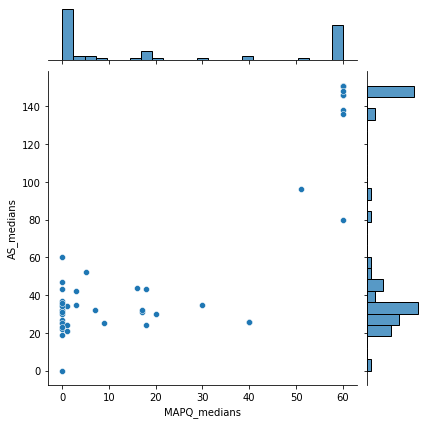

In [167]:
sns.jointplot(data=hits_df, x='MAPQ_medians', y='AS_medians', marginal_kws=dict(bins=25))

In [134]:
pd.concat([flags, mates, depths, MAPQ_medians, AS_medians])

,07C67140,mates,depths,MAPQ_medians,AS_medians
0,"[(1, 2), (0, 2)]",NaN,NaN,NaN,NaN
1,"[(0, 110), (1, 11)]",NaN,NaN,NaN,NaN
2,"[(1, 51), (0, 18)]",NaN,NaN,NaN,NaN
3,"[(1, 49), (0, 18)]",NaN,NaN,NaN,NaN
4,"[(0, 10), (1, 4)]",NaN,NaN,NaN,NaN
...,...,...,...,...,...
47,NaN,NaN,NaN,NaN,21.0
48,NaN,NaN,NaN,NaN,23.0
49,NaN,NaN,NaN,NaN,136.0
50,NaN,NaN,NaN,NaN,26.0


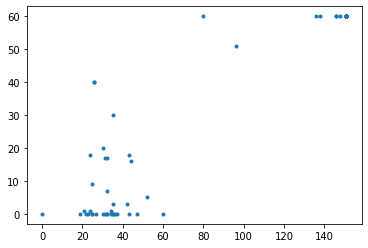

In [9]:
plt.plot(AS_medians, MAPQ_medians, '.')

In [145]:
hits_df

,start,end,length,n_sig,perc_sig
0,2910097.0,2910334.0,238.0,53,0.222689
1,10117717.0,10117938.0,222.0,22,0.099099
2,14535483.0,14535486.0,4.0,4,1.000000
3,16149215.0,16149245.0,31.0,31,1.000000
4,17303177.0,17303500.0,324.0,50,0.154321
5,31171927.0,31171950.0,24.0,17,0.708333
6,31221144.0,31221166.0,23.0,23,1.000000
7,31229779.0,31230468.0,690.0,43,0.062319
8,31243112.0,31243163.0,52.0,52,1.000000
9,35685523.0,35685547.0,25.0,6,0.240000


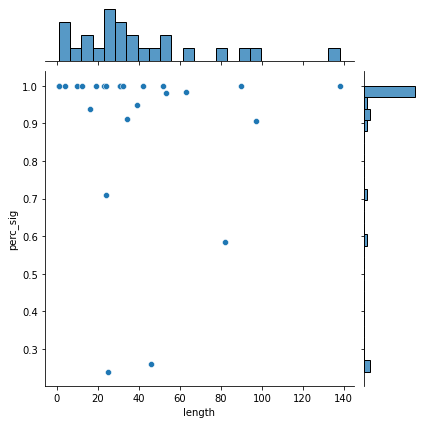

In [150]:
sns.jointplot(data=hits_df, x='length', y='perc_sig', marginal_kws=dict(bins=25))

In [151]:
sorted(np.array(sorted(starts)[1:]) - np.array(sorted(starts)[:-1]))[:10]

[185.0, 210.0, 225.0, 290.0, 367.0, 659.0, 8635.0, 12674.0, 18027.0, 31190.0]

(array([2., 0., 0., 3., 2., 2., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  1.  ,   7.89,  14.78,  21.67,  28.56,  35.45,  42.34,  49.23,
         56.12,  63.01,  69.9 ,  76.79,  83.68,  90.57,  97.46, 104.35,
        111.24, 118.13, 125.02, 131.91, 138.8 , 145.69, 152.58, 159.47,
        166.36, 173.25, 180.14, 187.03, 193.92, 200.81, 207.7 , 214.59,
        221.48, 228.37, 235.26, 242.15, 249.04, 255.93, 262.82, 269.71,
        276.6 , 283.49, 290.38, 297.27, 304.16, 311.05, 317.94, 324.83,
        331.72, 338.61, 345.5 , 352.39, 359.28, 366.17, 373.06, 379.95,
        386.84, 393.73, 400.62, 407.51, 414.4 

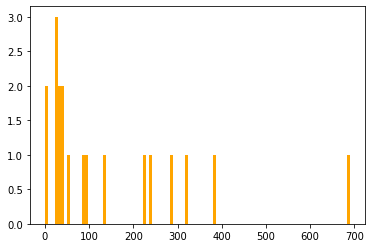

In [132]:
plt.hist(hits_df['diff'].values, color='orange', bins=100)

In [7]:
def CreatePileupDatFrame(pileup_type):
    array = [[] for h in loci_select]
    array_idx=0
    with open(
        '/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/tsv_files/chr20.q0.%s.tsv' % pileup_type) as f:
        for i, line in enumerate(f):
            if i==(loci_select[array_idx]+1):
                array[array_idx]=[float(f) for f in line.replace('\n', '').split('\t')]
                array_idx=array_idx+1
            if array_idx==len(loci_select):break

    pileup_df = pd.DataFrame(array)
    pileup_df.columns = ids
    pileup_df = pileup_df.T.unstack().reset_index()
    pileup_df.columns=['loci', 'sample_id', 'value']
    pileup_df.loci = [int(i) for i in loci_select[list(pileup_df['loci'].values)]]
    pileup_df['loci_str'] = [str(i) for i in pileup_df.loci.values]
    pileup_df['pileup_type'] = pileup_type
    pileup_df['sex'] = bam_mappings.loc[list(pileup_df.sample_id.values)].sex_numeric.values
    pileup_df['cluster'] = clusters_df.loc[list(pileup_df.loci.values)].cluster.values
    pileup_df['loci_str'] = [str(l) for l in pileup_df.loci.values]
    return pileup_df

improper_df = CreatePileupDatFrame('improper')
print('done with improper')

proper_df = CreatePileupDatFrame('proper')
print('done with proper')

unmapped_df = CreatePileupDatFrame('unmapped')
print('done with unmapped')

done with improper
done with proper
done with unmapped


In [8]:
improper_df = improper_df.sort_values(['loci', 'sample_id'])
proper_df = proper_df.sort_values(['loci', 'sample_id'])
unmapped_df = unmapped_df.sort_values(['loci', 'sample_id'])

In [9]:
all_pileup_df = pd.DataFrame(improper_df.value.values, columns=['improper'])
all_pileup_df['proper'] = proper_df.value.values
all_pileup_df['unmapped'] = unmapped_df.value.values
all_pileup_df['loci'] = unmapped_df.loci.values
all_pileup_df['sample_id'] = unmapped_df.sample_id.values
all_pileup_df['sex'] = unmapped_df.sex.values
all_pileup_df['total'] = proper_df.value.values + improper_df.value.values + unmapped_df.value.values
all_pileup_df['proper_frac'] = all_pileup_df['proper']/all_pileup_df['total']
all_pileup_df['improper_frac'] = all_pileup_df['improper']/all_pileup_df['total']
all_pileup_df['unmapped_frac'] = all_pileup_df['unmapped']/all_pileup_df['total']

#improper_df.sample_id.values,
#                              improper_df.value.values, proper_df.value.values, unmapped_df.value.values]).transpose()

In [10]:
proper_female = all_pileup_df[all_pileup_df.sex=='2.0'].groupby('loci')['proper'].aggregate(lambda x: list(x))
proper_male = all_pileup_df[all_pileup_df.sex=='1.0'].groupby('loci')['proper'].aggregate(lambda x: list(x))
p_proper = [stats.wilcoxon(np.array(i)-np.array(j)).pvalue if sum(i+j)>0 else 1 for i,j in zip(proper_female, proper_male)]

improper_female = all_pileup_df[all_pileup_df.sex=='2.0'].groupby('loci')['improper'].aggregate(lambda x: list(x))
improper_male = all_pileup_df[all_pileup_df.sex=='1.0'].groupby('loci')['improper'].aggregate(lambda x: list(x))
p_improper = [stats.wilcoxon(np.array(i)-np.array(j)).pvalue if sum(i+j)>0 else 1 for i,j in zip(improper_female, improper_male)]

unmapped_female = all_pileup_df[all_pileup_df.sex=='2.0'].groupby('loci')['unmapped'].aggregate(lambda x: list(x))
unmapped_male = all_pileup_df[all_pileup_df.sex=='1.0'].groupby('loci')['unmapped'].aggregate(lambda x: list(x))
p_unmapped = [stats.wilcoxon(np.array(i)-np.array(j)).pvalue if sum(i+j)>0 else 1 for i,j in zip(unmapped_female, unmapped_male)]

/home/users/briannac/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [95]:
proper_max = np.mean((all_pileup_df.proper_frac > all_pileup_df.improper_frac) & (all_pileup_df.proper_frac > all_pileup_df.unmapped_frac))
improper_max = np.mean((all_pileup_df.improper_frac > all_pileup_df.proper_frac) & (all_pileup_df.improper_frac > all_pileup_df.unmapped_frac))
unmapped_max = np.mean((all_pileup_df.unmapped_frac > all_pileup_df.improper_frac) & (all_pileup_df.unmapped_frac > all_pileup_df.proper_frac))
all_zero = np.mean((all_pileup_df.unmapped_frac == 0.0) & (all_pileup_df.improper_frac==0.0) & (all_pileup_df.proper_frac == 0.0))

In [42]:
cluster_num = 7
len(set(improper_df[improper_df.cluster==cluster_num].loci))

23

In [50]:
len(set(improper_df.loci))
len(pvals_sig)

878

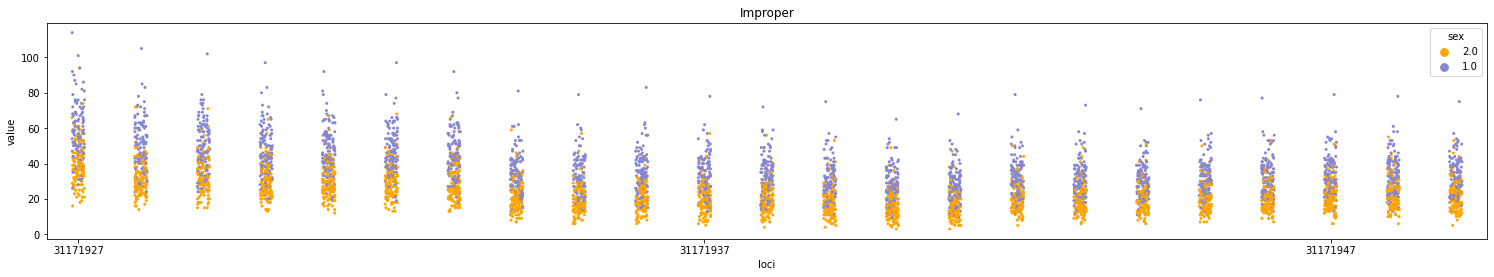

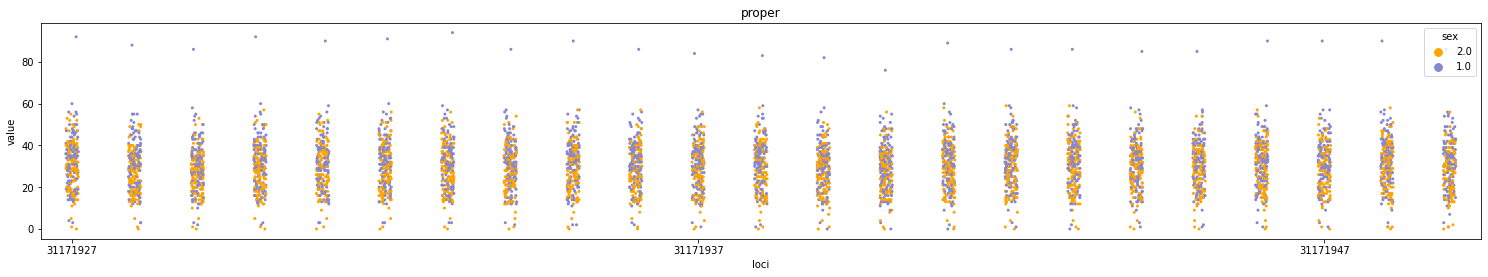

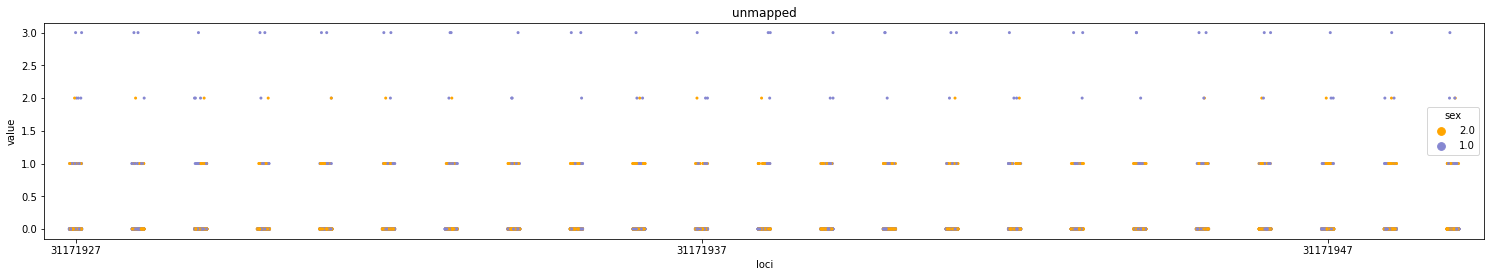

In [44]:
fig = plt.figure(figsize=(20,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
#log_ax.set_yscale("symlog")
sns.stripplot(data=improper_df[improper_df.cluster==cluster_num], x="loci", y="value", hue="sex", size=3, palette=['orange', '#8687d1'])
plt.title('Improper')
plt.xticks(np.arange(0, len(set(improper_df[improper_df.cluster==cluster_num].loci)), 10))
plt.show()

fig = plt.figure(figsize=(20,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
#log_ax.set_yscale("symlog")
sns.stripplot(data=proper_df[proper_df.cluster==cluster_num], x="loci", y="value", hue="sex", size=3, palette=['orange', '#8687d1'])
plt.title('proper')
plt.xticks(np.arange(0, len(set(proper_df[proper_df.cluster==cluster_num].loci)), 10))
plt.show()

fig = plt.figure(figsize=(20,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
#log_ax.set_yscale("symlog")
sns.stripplot(data=unmapped_df[unmapped_df.cluster==cluster_num], x="loci", y="value", hue="sex", size=3, palette=['orange', '#8687d1'])
plt.title('unmapped')
plt.xticks(np.arange(0, len(set(unmapped_df[unmapped_df.cluster==cluster_num].loci)), 10))
plt.show()

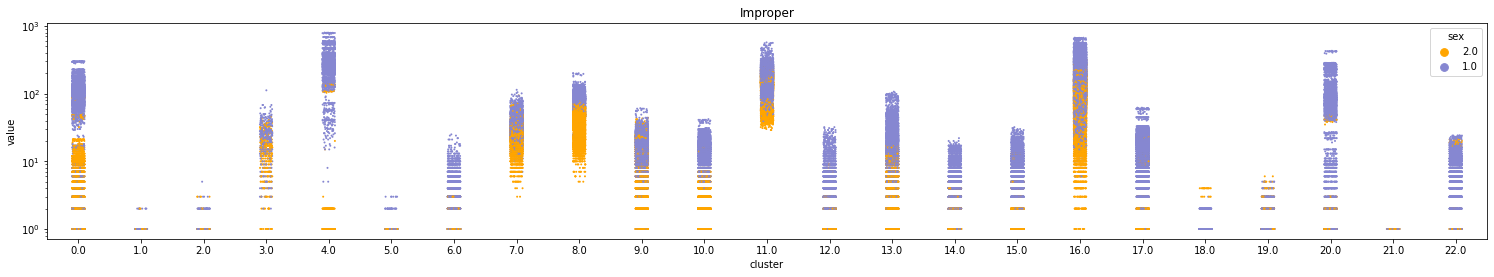

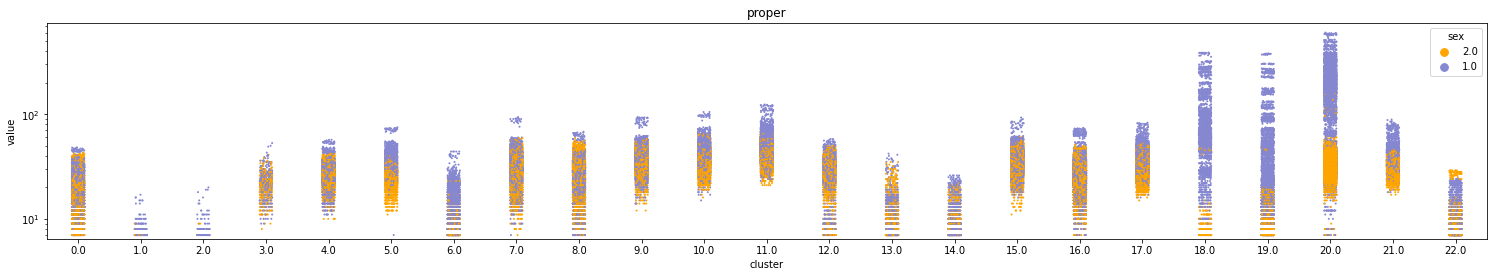

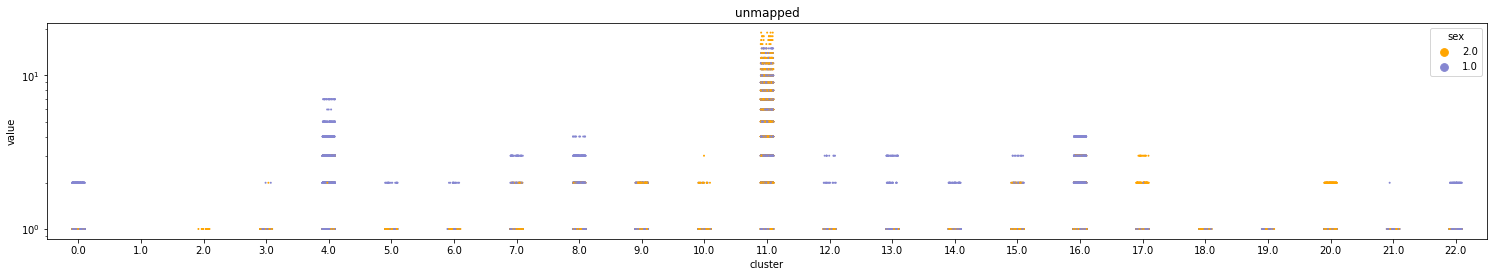

In [25]:
fig = plt.figure(figsize=(20,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
log_ax.set_yscale("log")
sns.stripplot(data=improper_df, x="cluster", y="value", hue="sex", size=2, palette=['orange', '#8687d1'])
plt.title('Improper')
plt.show()

fig = plt.figure(figsize=(20,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
log_ax.set_yscale("log")
sns.stripplot(data=proper_df, x="cluster", y="value", hue="sex", size=2, palette=['orange', '#8687d1'])
plt.title('proper')
plt.show()

fig = plt.figure(figsize=(20,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
log_ax.set_yscale("log")
sns.stripplot(data=unmapped_df, x="cluster", y="value", hue="sex", size=2, palette=['orange', '#8687d1'])
plt.title('unmapped')
plt.show()

In [38]:
%%bash
samtools view s3://ihart-hg38/cram/02C10859.final.cram chr20:17303177-17303197 | tail -n 10

E00170:120:H3T5FCCXX:4:1103:30628:61680	99	chr20	17303178	21	7S19M125S	=	17303480	324	ATATATGATATATAATATATATATTTGTAGTACATATTATAATTTTTATATATTATAATTTATATAATGATAAAATTTTTTATAGAATATAAATAATTATATATGATTATATAATTCTACATATTATAAATGAAAATATGTATAATTACAT	???????????????????????????????????????????????????????????????????????????????????????????????????????????????????????5??????????????????????+?5??????	SA:Z:chrUn_JTFH01000876v1_decoy,535,-,151M,0,9;	MC:Z:36S22M93S	PG:Z:MarkDuplicates	MQ:i:21	AS:i:19	XS:i:26	pa:f:0.179	MD:Z:19	NM:i:0	RG:Z:02C10859_CTGAAGCT_H3T5FCCXX_L004
E00170:120:H3T5FCCXX:4:1104:4400:71278	163	chr20	17303178	3	117S22M12S	=	17303480	324	CATATATAATATATGATACATATTATACATCTTATATATGAAATTATATAATTATAGATAACATAATACACATTTATATGTATTATGATATATAACAAAGGTACTATATCATATATGATATATAATATATATATTTATAGTACATATTATA	?????????????????????????????????????????????????????5???????+????????????????????????????????????+'+???????????????5??????5????????+55?++????5???????+	SA:Z:chrUn_JTFH01000876v1_decoy,645,-,151M,15,13;

In [171]:


proper_df = pd.DataFrame(proper)
proper_df.columns = ids
proper_df = proper_df.T.unstack().reset_index()
proper_df.columns=['loci', 'sample_id', 'value']
proper_df.index = [int(i) for i in loci_select[list(proper_df['loci'].values)]]
proper_df['pileup_type'] = 'proper'
proper_df['sex'] = bam_mappings.loc[list(proper_df.sample_id.values)].sex_numeric.values
proper_df['cluster'] = clusters_df.loc[list(proper_df.index)].cluster



In [37]:
proper_df = proper_df.T.unstack().reset_index()
proper_df.columns=['loci', 'sample_id', 'value']
proper_df['pileup_type'] = 'proper'
proper_df['sex'] = bam_mappings.loc[list(proper_df.sample_id.values)].sex_numeric.values

In [38]:
proper_df

,loci,sample_id,value,pileup_type,sex
0,0,02C10855,11.0,proper,2.0
1,0,02C10859,22.0,proper,1.0
2,0,02C10948,11.0,proper,2.0
3,0,02C10949,16.0,proper,1.0
4,0,02C10953,18.0,proper,2.0
...,...,...,...,...,...
2191,8,HI1046,0.0,proper,2.0
2192,8,HI1047,2.0,proper,1.0
2193,8,HI2799,0.0,proper,2.0
2194,8,MH0138049,27.0,proper,2.0


In [ ]:
fig = plt.figure(figsize=(10,20)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
log_ax.set_xscale("symlog")
plt.figure(figsize=(10,20))

In [2]:
df = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/test_issues/p_values/normalized_with_frac_wilcox_more_samples/tsv_files/20.q0.proper.tsv',
                 sep='\t')

In [25]:
x = np.array([[.1, .3, .4, .2], [.2, .2, .1, .5], [.2, .2, .1, .5], [.2, .2, .1, .5]])
clr(x)

array([[-0.79451346,  0.30409883,  0.5917809 , -0.10136628],
       [-0.05578589, -0.05578589, -0.74893307,  0.86050484],
       [-0.05578589, -0.05578589, -0.74893307,  0.86050484],
       [-0.05578589, -0.05578589, -0.74893307,  0.86050484]])

In [24]:
x = np.array([[.1, .3, .4, .2]])
clr(x)

array([-0.79451346,  0.30409883,  0.5917809 , -0.10136628])

In [13]:
df=(df+1)/999999

In [14]:
clr(df.transpose())

array([[-1.00000042e-06, -1.00000042e-06, -1.00000042e-06, ...,
         1.16516192e-07,  8.26823747e-08,  1.50350010e-07],
       [-1.00000042e-06, -1.00000042e-06, -1.00000042e-06, ...,
        -3.58179513e-08, -2.57029775e-09, -2.57029775e-09],
       [-1.00000044e-06, -1.00000044e-06, -1.00000044e-06, ...,
         1.75942256e-07,  2.33305279e-07,  2.33305279e-07],
       ...,
       [-1.00000043e-06, -1.00000043e-06, -1.00000043e-06, ...,
         2.10242991e-07,  2.77478694e-07,  3.11096544e-07],
       [-1.00000042e-06, -1.00000042e-06, -1.00000042e-06, ...,
        -1.93799123e-07, -1.60207417e-07, -1.26615712e-07],
       [-1.00000042e-06, -1.00000042e-06, -1.00000042e-06, ...,
         2.33739657e-07,  3.24013262e-07,  2.93922062e-07]])

In [8]:
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/test_issues/p_values/normalized_with_frac_wilcox_more_samples/tsv_files/21.q0.proper.pvals.tsv') as my_csv:
    lines=my_csv.readlines()
loci = np.array([int(l) for l in lines[0].replace('\n', '').split(' ')])
pvals = np.array([float(l) for l in lines[1].replace('\n', '').split(' ')])

In [13]:
bam_mappings.loc['03C23217'].sex_numeric

'2.0'

In [28]:
%%bash
#samtools view s3://ihart-hg38/cram/03C23218.final.cram chr21:34178994-34179073 -c
samtools view s3://ihart-hg38/cram/05C40763.f inal.cram chr21:3770827-3774590 -c

0


In [22]:
bam_mappings.iloc[:20]

,status,sample_id,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
sample_id,,,,,,,,,,,,,,,,,,,,,
02C10540,Passed_QC_analysis_ready,02C10540,AU1005201,AU1005,HI2393,02C10540,father,0,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10541,Passed_QC_analysis_ready,02C10541,AU1005202,AU1005,HI2394,02C10541,mother,0,0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10542,Passed_QC_analysis_ready,02C10542,AU1005302,AU1005,HI2395,02C10542,sibling,AU1005201,AU1005202,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10543,Passed_QC_analysis_ready,02C10543,AU1005301,AU1005,HI2396,02C10543,sibling,AU1005201,AU1005202,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10702,Passed_QC_analysis_ready,02C10702,AU1004202,AU1004,HI2397,02C10702,mother,0,0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10704,Passed_QC_analysis_ready,02C10704,AU1004301,AU1004,HI2399,02C10704,sibling,AU1004201,AU1004202,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10778,HOLD:IBD_pending,02C10778,AU0920201,AU0920,HI2400,02C10778,father,0,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10779,HOLD:IBD_pending,02C10779,AU0920202,AU0920,HI2401,02C10779,mother,0,0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02C10780,HOLD:IBD_pending,02C10780,AU0920301,AU0920,HI2402,02C10780,sibling,AU0920201,AU0920202,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
sorted_ids = np.argsort(pvals)

In [59]:

starts, ends

(array([ 3770827., 34178994.]), array([ 3774590., 34179073.]))

In [46]:
p_thresh = .05/3000000000

In [84]:
p=stats.wilcoxon([np.random.random() for i in range(100)]).pvalue
print(p, p_thresh, p<p_thresh)

3.896559845095909e-18 1.6666666666666667e-11 True


In [11]:
bam_dir='/scratch/groups/dpwall/personal/chloehe/unmapped_reads/bam/archived/batch_00514'
bam_mappings = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/data/bam_mappings.csv', sep='\t')
bam_mappings.index = bam_mappings.sample_id
samples = [a.split('/')[-2] for a in glob.glob(bam_dir +'/*/')]
print(samples[2])
print(bam_mappings.loc[samples[2]].sex_numeric)

07C65106
1.0


In [ ]:
bam_mappings

In [7]:
bam_mappings.loc['03C23217'].sex_numeric


'2.0'

In [ ]:
%%bash
samtools view s3://ihart-hg38/cram/03C23218.final.cram chr21:3770827-19770827 | head -n 10

In [1]:
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/results/tsv_files/chr20.q0.norm.pvals.tsv') as my_csv:
    lines=my_csv.readlines()
loci = np.array([int(l) for l in lines[0].replace('\n', '').split(' ')])
pvals = np.array([float(l) for l in lines[1].replace('\n', '').split(' ')])
#loci = loci[pvals!=.8553986045913681]
#pvals = pvals[pvals!=.8553986045913681]


NameError: name 'np' is not defined

In [3]:
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/test_issues/p_values/normalized_with_frac_wilcox_more_samples/tsv_files/21.q0.improper.pvals.tsv') as my_csv:
    lines=my_csv.readlines()
loci = np.array([int(l) for l in lines[0].replace('\n', '').split(' ')])
pvals = np.array([float(l) for l in lines[1].replace('\n', '').split(' ')])

In [16]:
chunks = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/test_issues/p_values/normalized_with_frac_wilcox_more_samples/tsv_files/21.q0.improper.tsv',
           sep='\t', chunksize=1000000)

In [54]:
done=False
for chunk in chunks:
    if chunk.sum().sum()>0: done=True
    if done: break

In [39]:
chunk = chunk[chunk.sum(axis=1)>0]

In [40]:
females = chunk[list(bam_mappings[bam_mappings.sex_numeric=='2.0'].index.intersection(chunk.columns))]
males = chunk[list(bam_mappings[bam_mappings.sex_numeric=='1.0'].index.intersection(chunk.columns))]
levels = pd.concat([males, females], axis=1)

In [76]:
bam_mappings[bam_mappings.family=='AU0164']

,status,sample_id,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
sample_id,,,,,,,,,,,,,,,,,,,,,
03C16026,Passed_QC_analysis_ready,03C16026,AU016401,AU0164,HI0436,03C16026,mother,0,0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16027,Passed_QC_analysis_ready,03C16027,AU016403,AU0164,HI0437,03C16027,sibling,AU016402,AU016401,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16028,Passed_QC_analysis_ready,03C16028,AU016404,AU0164,HI0442,03C16028,sibling,AU016402,AU016401,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16639,Passed_QC_analysis_ready,03C16639,AU016402,AU0164,HI2210,03C16639,father,0,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


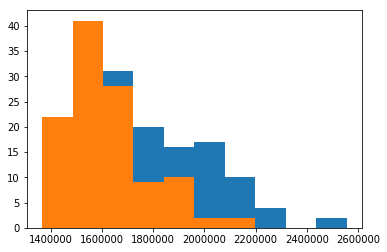

In [53]:
a=plt.hist(females.sum(axis=0).values, bins=10)
plt.hist(males.sum(axis=0).values, bins=a[1])
plt.show()

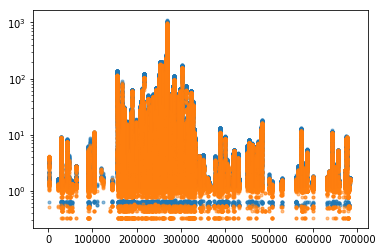

In [48]:
plt.plot(females.median(axis=1).values, '.', alpha=.5)
plt.plot(males.median(axis=1).values, '.', alpha=.5)
plt.yscale('log')

In [ ]:
chunk[bam_mappings[bam_mappings.sex_numeric=='1.0'].index].head()

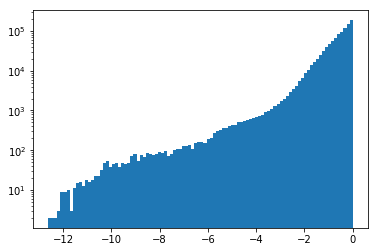

In [20]:
plt.hist(np.log10(pvals[:1000000]), bins=100)
plt.yscale('log')

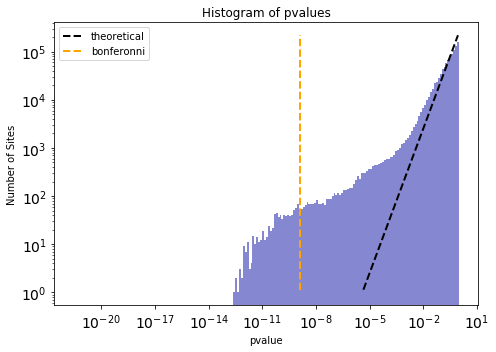

In [9]:
def genomic_inflation_plot(pvalues, binsize=.1):
    # expects numpy array of pvalues
    plt.figure(figsize=(7, 5))
    indices = ~np.isnan(pvalues) #& np.all(np.sum(all_allele_counts, axis=1)>100, axis=1)
    a = np.power(12.0, -np.arange(20, -binsize, -binsize))
    # hist
    ax = plt.subplot(1, 1, 1)
    n, bins, _ = plt.hist(np.clip(pvalues[indices], 10.0**(-20), None), 
                          bins=a, log=True, color='#8687d1')
    # theoretical - expect pvalues to follow a uniform distribution between 0-1
    exp = np.sum(indices)*(bins[1:]-bins[:-1])
    plt.plot(10**(binsize/2) * a[:-1][exp>1], exp[exp>1], color='black', linestyle='--', linewidth=2, label='theoretical')
    plt.xlabel('pvalue')
    plt.ylabel('Number of Sites')
    plt.title('Histogram of pvalues')
    plt.xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.plot([.05/len(pvals) for _ in exp[exp>1]], exp[exp>1], color='orange', linestyle='--', linewidth=2, label='bonferonni')
    plt.legend()
    plt.tight_layout()
    plt.show()


genomic_inflation_plot(pvals[:1000000], binsize=.1)

In [ ]:
plt.plot(-np.log10(pvals[:1000000]), '.')

In [16]:
chunks = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/test_issues/p_values/normalized_with_frac_wilcox_more_samples/tsv_files/21.q0.proper.tsv',
                sep='\t', chunksize=1000000)

In [18]:
i=0
for chunk in chunks:
    if (chunk!=0).sum().sum():
        print(i)
        break
    i = i + 1

0


02C10855     2.0
02C10857     1.0
02C10948     2.0
02C10949     1.0
02C10953     2.0
            ... 
HI1046       2.0
HI1047       1.0
HI2799       2.0
MH0138049    2.0
MH0138054    1.0
Name: sex_numeric, Length: 244, dtype: object

In [44]:
%%bash
aws s3 ls ihart-hg38/cram/ > /scratch/groups/dpwall/personal/briannac/unmapped_reads/data/file_dirs_on_aws.tsv
#head -n 10 $MY_SCRATCH/unmapped_reads/pileups/test_issues/p_values/normalized_with_frac_wilcox_more_samples/tsv_files/21.q0.02C10855.proper.txt

In [19]:
for chunk in chunks:
    if (chunk!=0).sum().sum():
        print(i)
        break
    i = i + 1

,02C10855,02C10857,02C10948,02C10949,02C10953,02C10954,02C11037,02C11038,02C11096,02C11098,...,11C125703,HI0161,HI0163,HI0519,HI0522,HI1046,HI1047,HI2799,MH0138049,MH0138054
0,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0
1,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0
2,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0
3,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0
4,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0
999996,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0
999997,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0
999998,NaN,0,NaN,0,NaN,0,0,NaN,NaN,0,...,0,NaN,NaN,0,NaN,0,0,NaN,0,0


(array([19.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.32338357, 0.64676713, 0.9701507 , 1.29353426,
        1.61691783, 1.94030139, 2.26368496, 2.58706852, 2.91045209,
        3.23383565]),
 <a list of 10 Patch objects>)

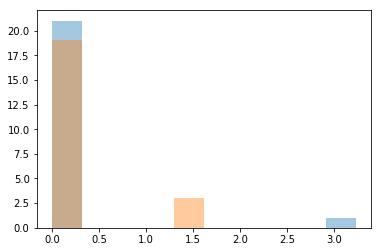

In [351]:
n=np.random.randint(len(chunk))
bins=plt.hist(chunk.iloc[n][females], bins=10, alpha=.4)
plt.hist(chunk.iloc[n][males], bins=bins[1], alpha=.4)

In [195]:
chunks = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/pileups/test_issues/p_values/normalized_with_frac/tsv_files/21.q0.proper.tsv',
                sep='\t', chunksize=1000000)

In [21]:
ids = bam_mappings.loc[list(chunk.columns)]       
males = ids[ids.sex_numeric=='1.0'].index
females = ids[ids.sex_numeric=='2.0'].index

In [22]:
chunk[chunk.]

Index(['03C15941', '03C16034', '03C16939', '03C23218', '04C34397', '04C38281',
       '05C40054', '05C46568', '05C48922', '06C61140', '06C61443', '07C62248',
       '07C65106', '07C67140', '07C70156', '07C70195', '08C73539', '10C111722',
       '11C125634', '11C125699', 'HI1047', 'MH0138054'],
      dtype='object', name='sample_id')

In [197]:
i=0
for chunk in chunks:
    if (chunk!=0).sum().sum():
        print(i)
        break
    i = i + 1

5


In [24]:
chunk[chunk.sum(axis=1)>0].iloc[:10]

,03C15941,03C16034,03C16035,03C16793,03C16939,03C23212,03C23218,04C33619,04C34393,04C34397,...,10C111728,11C123714,11C125631,11C125634,11C125699,11C125703,HI1046,HI1047,MH0138049,MH0138054
5010000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.029519,0.000000,0.000000,0.000000
5010001,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.029519,0.000000,0.000000,0.000000
5010002,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.034382,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.029519,0.000000,0.000000,0.000000
5010003,0.026159,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.034382,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.029519,0.000000,0.000000,0.000000
5010004,0.026159,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.034382,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.029519,0.000000,0.000000,0.000000
5010005,0.026159,0.0,0.0,0.0,0.000000,0.0,0.029979,0.0,0.034382,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.029519,0.000000,0.032832,0.000000
5010006,0.026159,0.0,0.0,0.0,0.030245,0.0,0.029979,0.0,0.034382,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.059037,0.000000,0.032832,0.000000
5010007,0.026159,0.0,0.0,0.0,0.030245,0.0,0.029979,0.0,0.034382,0.035599,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.059037,0.000000,0.032832,0.000000
5010008,0.026159,0.0,0.0,0.0,0.030245,0.0,0.029979,0.0,0.034382,0.035599,...,0.031105,0.0,0.00000,0.0,0.0,0.0,0.059037,0.032316,0.065664,0.000000
5010009,0.026159,0.0,0.0,0.0,0.030245,0.0,0.029979,0.0,0.068763,0.035599,...,0.031105,0.0,0.02648,0.0,0.0,0.0,0.059037,0.064632,0.065664,0.029605


In [198]:
chunk=chunk[chunk.sum(axis=1)>0]

In [199]:
len(chunk)

690003

In [71]:
males=list(bam_mappings.loc[males].sort_values('family').index)
females = list(bam_mappings.loc[females].sort_values('family').index)


In [87]:
import time

In [156]:
itera[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03774344, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [206]:
%%bash
pip3 install from pandarallel

#import swifter

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for from: filename=from-0.1.0-py3-none-any.whl size=1359 sha256=e69cfc3714e38194a80e250cd5b68cc3c191b1a07d93d2930df5183504aed545
  Stored in directory: /home/users/briannac/.cache/pip/wheels/46/06/88/cc018a5f0809d3fdd159e723a850c9267f7abf37a3e5a932ac
  Created wheel for pandarallel: filename=pandarallel-1.5.1-py3-none-any.whl size=17126 sha256=c579a2d3c22809c93f6585cd14d1fbe8ffea51b401c4ad2056369642934d3773
  Stored in directory: /home/users/briannac/.cache/pip/wheels/ff/16/08/8b7670bae42ee25a76e619ac5ad8d12940953bf21ff1eda410
Successfully built from pandarallel


In [208]:
from pandarallel import pandarallel
pandarallel.initialize()

males=list(bam_mappings.loc[males].sort_values('family').index)
females = list(bam_mappings.loc[females].sort_values('family').index)
a=chunk[males]
b=chunk[females]
a.columns = bam_mappings.loc[a.columns].family.values
b.columns = bam_mappings.loc[b.columns].family.values
diff = a-b
print('here')
ps = diff.parallel_apply(axis=1, func=lambda x: stats.wilcoxon(x).pvalue)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
here


/share/software/user/open/py-scipy/1.1.0_py36/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/share/software/user/open/py-scipy/1.1.0_py36/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/share/software/user/open/py-scipy/1.1.0_py36/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/share/software/user/open/py-scipy/1.1.0_py36/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation

<Figure size 1440x216 with 0 Axes>

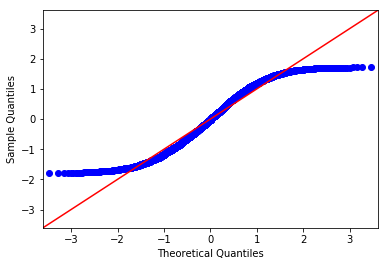

In [370]:
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
plt.figure(figsize=(20,3))
qqplot(pvals[::10000], stats.t, fit=True, line="45")
plt.show()

In [49]:
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65104.improper.txt') as f:
    lines = f.readlines()
female_improper = np.array([float(l.replace('\n', '')) for l in lines[1:]])
print('done w female')
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65103.improper.txt') as f:
    lines = f.readlines()
male_improper = np.array([float(l.replace('\n', '')) for l in lines[1:]])


with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65104.unmapped.txt') as f:
    lines = f.readlines()
female_umapped = np.array([float(l.replace('\n', '')) for l in lines[1:]])
print('done w female')
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65103.unmapped.txt') as f:
    lines = f.readlines()
male_umapped = np.array([float(l.replace('\n', '')) for l in lines[1:]])

with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65104.proper.txt') as f:
    lines = f.readlines()
female_proper = np.array([float(l.replace('\n', '')) for l in lines[1:]])
print('done w female')
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65103.proper.txt') as f:
    lines = f.readlines()
male_proper = np.array([float(l.replace('\n', '')) for l in lines[1:]])


done w female
done w female
done w female


In [25]:
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65104.proper.txt.norm') as f:
    lines = f.readlines()
female_proper = np.array([float(l.replace('\n', '')) for l in lines[1:]])
print('done w female')
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65103.proper.txt.norm') as f:
    lines = f.readlines()
male_proper = np.array([float(l.replace('\n', '')) for l in lines[1:]])


done w female


In [50]:
print('improper:', sum(female_improper)/sum(male_improper))
print('unmapped:', sum(female_umapped)/sum(male_umapped))
print('proper:', sum(female_proper)/sum(male_proper))

improper: 0.7160437844884765
unmapped: 1.529072386120414
proper: 1.0073190124406328


In [29]:
sum(female_umapped)

46709983.00129934

In [51]:
np.percentile(male_improper, 99.99)

532.0

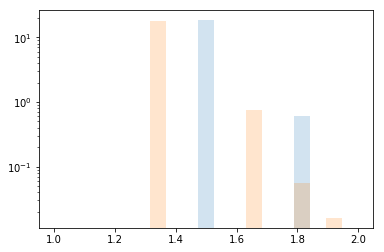

In [39]:
plt.hist(np.log10(male_umapped[male_umapped>0]), bins=np.linspace(1,2,20), alpha=.2, density=True)
plt.hist(np.log10(female_umapped[female_umapped>0]), bins=np.linspace(1,2,20), alpha=.2, density=True)
plt.yscale('log')
plt.show()

In [75]:
plt.plot(male_umap)

0.9759836643367602

In [81]:
sum(female_improper)/(sum(female_improper) + sum(female_proper))

#/sum(male_improper)

0.02023932656300819

In [106]:
a = female_improper/male_improper
np.mean(a[~np.isinf(a) & ~np.isnan(a) & (a>0)])

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


1.2113133684901045

In [108]:
sum(female_improper)/sum(male_improper)

0.7760948236642502

In [100]:
a[~np.isinf(a) & ~np.isnan(a) & (a>0)]

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([1.        , 1.        , 1.        , ..., 1.71428571, 1.66666667,
       4.        ])

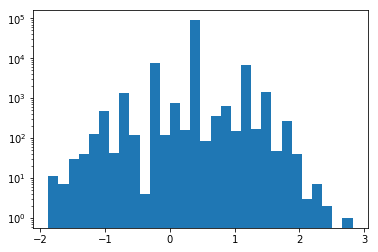

In [44]:
plt.hist(np.log(male_umapped[(male_umapped>0) & (female_umapped>0)]/sum(male_umapped)*sum(female_umapped)/female_umapped[(male_umapped>0) & (female_umapped>0)]), bins=30)
plt.yscale('log')
plt.show()

In [45]:
sum(male_mapped>0)

KeyboardInterrupt: 

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


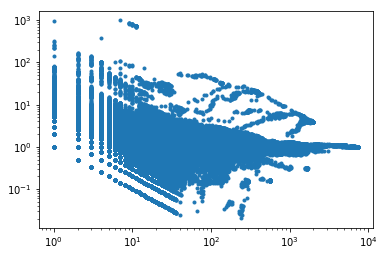

In [74]:
plt.plot(female_improper, male_improper/female_improper,'.')
plt.yscale('log')
plt.xscale('log')

In [16]:
sum(male_proper)/sum(female_proper)

1421789928.0

In [17]:
sum(male_proper)

1456776358.0

In [95]:
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.09C82722.improper.txt') as f:
    lines = f.readlines()
female_improper = np.array([float(l.replace('\n', '')) for l in lines[1:]])
print('done w female')
with open('/scratch/groups/dpwall/personal/briannac/unmapped_reads/results/pileups/21.07C65106.improper.txt') as f:
    lines = f.readlines()
male_improper = np.array([float(l.replace('\n', '')) for l in lines[1:]])



done w female


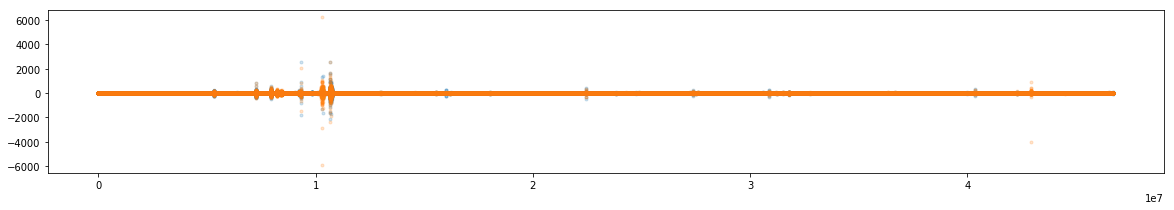

In [136]:
plt.figure(figsize=(20,3))
plt.plot((female_improper[1:]-female_improper[:-1]), '.', alpha=.2, label='female')
plt.plot((male_improper[1:]-male_improper[:-1]), '.', alpha=.2, label='male')
#plt.yscale('log')

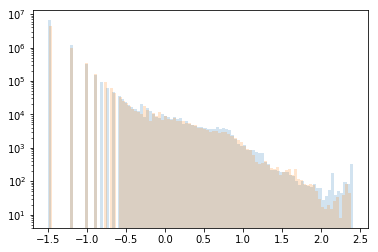

In [32]:
plt.hist(np.log10(male_improper[male_improper>0]), bins=100, alpha=.2)
plt.yscale('log')

plt.hist(np.log10(female_improper[female_improper>0]), bins=100, alpha=.2)
plt.yscale('log')

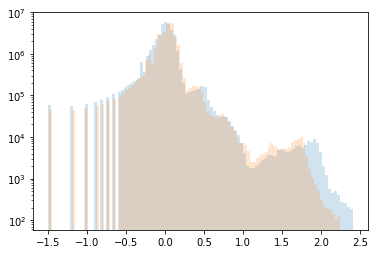

In [31]:
plt.hist(np.log10(male_proper[male_proper>0]), bins=100, alpha=.2)
plt.yscale('log')

plt.hist(np.log10(female_proper[female_proper>0]), bins=100, alpha=.2)
plt.yscale('log')

In [59]:
sum(male_improper)

1213426.4349903306

In [63]:
from skbio.stats.composition import clr

In [75]:
male_clr=clr(male_improper+1)
female_clr=clr(female_improper+1)

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(male_clr, '.', alpha=.2)
plt.plot(female_clr, '.', alpha=.2)

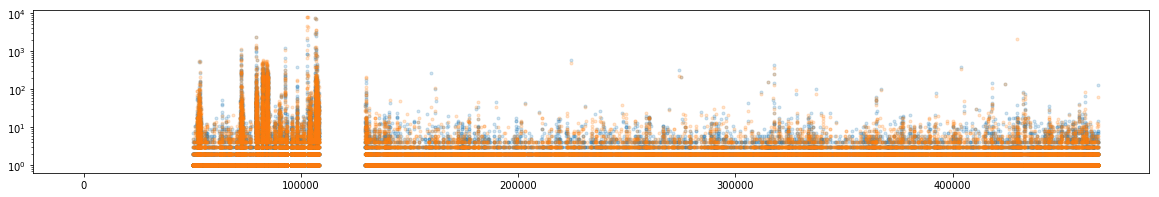

In [17]:
plt.figure(figsize=(20,3))
plt.plot(female_improper[::100], '.', alpha=.2, label='male')
plt.plot(male_improper[::100], '.', alpha=.2)
plt.yscale('log')

In [49]:
print(np.sum(female_proper))
print(np.sum(male_proper))

1421789928
1456776358


In [53]:
np.sum(female_proper + male_proper)

2878566286